### the number of neurons in the fully connected layers
The hyperparameter assigned to me was the number of neurons in the fully connected layers. Each neuron in the fully connected layers is responsible for detecting specific image features. The number displayed in a neuron represents the confidence level of that neuron in identifying a particular feature. (https://builtin.com/machine-learning/fully-connected-layer)

Increasing the number of neurons in the fully connected layers allows the network to capture a greater variety of image features. This means that the computer can consider more details when making predictions.

For my experiment, I selected different numbers of neurons: 1, 2, 32, 64, 256, 512, and 1024. The values of 64 and 256 were taken from the example code. I assumed that increasing the number of neurons would improve the accuracy of the predictions, but it would also increase the training time.

In [73]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

### helper function to load and parse annotations

In [74]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'../../gesture_dataset_sample/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [75]:
# pretty-print first element
print(json.dumps(annotations['like']['0014182f-d756-42b3-896c-c52de76926bb'], indent=2))

{
  "bboxes": [
    [
      0.38056273,
      0.35650891,
      0.17322347,
      0.10461114
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    [
      [
        0.5497169170918876,
        0.4276043615779976
      ],
      [
        0.5218336293004483,
        0.40536586667786917
      ],
      [
        0.48288133220125257,
        0.3930262243722419
      ],
      [
        0.4501841862302019,
        0.37981099195030416
      ],
      [
        0.44251365410099686,
        0.36620499322043343
      ],
      [
        0.43138297470865106,
        0.406093902776592
      ],
      [
        0.4072660997339628,
        0.4073950234480344
      ],
      [
        0.42588200316326846,
        0.40612291879594015
      ],
      [
        0.4441470003072778,
        0.4049221293588555
      ],
      [
        0.4314493576491367,
        0.4212979654419442
      ],
      [
        0.42096276272263283,
        0.4180224457320293
      ],
      [
        0.43966095717106257,
      

### helper function to pre-process images (color channel conversion and resizing)

In [76]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

### load images and annotations

In [77]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir("../../gesture_dataset_sample/"+condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{"../../gesture_dataset_sample/"+condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

### split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


### transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [79]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


In [80]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neuron_1 = 1
num_neurons_2 = 2
num_neurons_32 = 32
num_neurons_64 = 64
num_neurons_256 = 256
num_neurons_512 = 512
num_neurons_1024 = 1024

#### One neuron in the fully connected layers

In [81]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_1 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_1.add(RandomFlip('horizontal'))
model_1.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_1.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_1.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_1.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_1.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model_1.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_1.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_1.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_1.add(Dense(num_neuron_1, activation=activation))

model_1.add(Dense(num_neuron_1, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_1.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_1.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

##### Train the model using the fit() function

In [124]:
history_1 = model_1.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 5s 85ms/step - loss: 1.0664 - accuracy: 0.4004 - val_loss: 1.0730 - val_accuracy: 0.3516 - lr: 2.0000e-04
Epoch 2/50
64/64 [==============================] - 5s 81ms/step - loss: 1.0664 - accuracy: 0.4004 - val_loss: 1.0730 - val_accuracy: 0.3516 - lr: 2.0000e-04
Epoch 3/50
64/64 [==============================] - 6s 87ms/step - loss: 1.0663 - accuracy: 0.4004 - val_loss: 1.0730 - val_accuracy: 0.3516 - lr: 2.0000e-04
Epoch 4/50
64/64 [==============================] - 5s 86ms/step - loss: 1.0663 - accuracy: 0.4004 - val_loss: 1.0730 - val_accuracy: 0.3516 - lr: 1.0000e-04
Epoch 5/50
64/64 [==============================] - 5s 83ms/step - loss: 1.0663 - accuracy: 0.4004 - val_loss: 1.0730 - val_accuracy: 0.3516 - lr: 1.0000e-04
Epoch 6/50
64/64 [==============================] - 5s 80ms/step - loss: 1.0663 - accuracy: 0.4004 - val_loss: 1.0730 - val_accuracy: 0.3516 - lr: 1.0000e-04
Epoch 7/50
64/64 [==============================] - 

#### Two neurons in the fully connected layers

In [83]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_2 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_2.add(RandomFlip('horizontal'))
model_2.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_2.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_2.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_2.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model_2.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_2.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_2.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_2.add(Dense(num_neurons_2, activation=activation))

model_2.add(Dense(num_neurons_2, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_2.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_2.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

##### Train the model using the fit() function

In [123]:
history_2 = model_2.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 7s 105ms/step - loss: 0.1812 - accuracy: 0.9805 - val_loss: 0.2759 - val_accuracy: 0.9609 - lr: 1.0000e-04
Epoch 2/50
64/64 [==============================] - 6s 87ms/step - loss: 0.1778 - accuracy: 0.9883 - val_loss: 0.2732 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 3/50
64/64 [==============================] - 6s 92ms/step - loss: 0.1763 - accuracy: 0.9844 - val_loss: 0.2759 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 4/50
64/64 [==============================] - 6s 94ms/step - loss: 0.1747 - accuracy: 0.9883 - val_loss: 0.2778 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 5/50
64/64 [==============================] - 7s 102ms/step - loss: 0.1796 - accuracy: 0.9785 - val_loss: 0.2716 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 6/50
64/64 [==============================] - 6s 98ms/step - loss: 0.1711 - accuracy: 0.9902 - val_loss: 0.2865 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 7/50
64/64 [==============================] 

#### 32 neuron in the fully connected layers

In [86]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_32 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_32.add(RandomFlip('horizontal'))
model_32.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_32.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_32.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_32.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_32.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model_32.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_32.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_32.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_32.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_32.add(Dense(num_neurons_32, activation=activation))

model_32.add(Dense(num_neurons_32, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_32.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_32.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

##### Train the model using the fit() function

In [88]:
history_32 = model_32.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 6s 94ms/step - loss: 0.7577 - accuracy: 0.6719 - val_loss: 0.5093 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 6s 89ms/step - loss: 0.4501 - accuracy: 0.8242 - val_loss: 0.2744 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 6s 95ms/step - loss: 0.2743 - accuracy: 0.9004 - val_loss: 0.5218 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 6s 89ms/step - loss: 0.2307 - accuracy: 0.9277 - val_loss: 0.4052 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 6s 90ms/step - loss: 0.1722 - accuracy: 0.9570 - val_loss: 0.2443 - val_accuracy: 0.9297 - lr: 2.0000e-04
Epoch 6/50
64/64 [==============================] - 6s 90ms/step - loss: 0.1139 - accuracy: 0.9668 - val_loss: 0.2213 - val_accuracy: 0.9219 - lr: 2.0000e-04
Epoch 7/50
64/64 [==============================] - 6s 90ms/step - l

#### 64 neurons in the fully connected layers

In [89]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_64 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_64.add(RandomFlip('horizontal'))
model_64.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_64.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_64.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_64.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_64.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model_64.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_64.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_64.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_64.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_64.add(Dense(num_neurons_64, activation=activation))

model_64.add(Dense(num_neurons_64, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_64.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_64.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

##### Train the model using the fit() function

In [90]:
history_64 = model_64.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 7s 85ms/step - loss: 1.0509 - accuracy: 0.4375 - val_loss: 1.0711 - val_accuracy: 0.4766 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 5s 83ms/step - loss: 1.0172 - accuracy: 0.4727 - val_loss: 1.0386 - val_accuracy: 0.4453 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 5s 83ms/step - loss: 0.8905 - accuracy: 0.5664 - val_loss: 0.8555 - val_accuracy: 0.5703 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 6s 90ms/step - loss: 0.7264 - accuracy: 0.7012 - val_loss: 0.4617 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 5s 83ms/step - loss: 0.4025 - accuracy: 0.8711 - val_loss: 0.5286 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 5s 82ms/step - loss: 0.3898 - accuracy: 0.8672 - val_loss: 0.4190 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 5s 82ms/step - loss: 0.2

#### 256 neurons in the fully connected layers

In [91]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_256 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_256.add(RandomFlip('horizontal'))
model_256.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_256.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_256.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_256.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_256.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model_256.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_256.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_256.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_256.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_256.add(Dense(num_neurons_256, activation=activation))

model_256.add(Dense(num_neurons_256, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_256.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_256.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

##### Train the model using the fit() function

In [92]:
history_256 = model_256.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 7s 85ms/step - loss: 1.0686 - accuracy: 0.4023 - val_loss: 1.0630 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 6s 87ms/step - loss: 0.9621 - accuracy: 0.5410 - val_loss: 0.7460 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 6s 87ms/step - loss: 0.6742 - accuracy: 0.7168 - val_loss: 0.5057 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 6s 92ms/step - loss: 0.5754 - accuracy: 0.7910 - val_loss: 0.3540 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 6s 90ms/step - loss: 0.2989 - accuracy: 0.8887 - val_loss: 0.2479 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 6s 94ms/step - loss: 0.2547 - accuracy: 0.9062 - val_loss: 0.2533 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 5s 84ms/step - loss: 0.2

#### 512 neurons in the fully connected layers

In [93]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_512 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_512.add(RandomFlip('horizontal'))
model_512.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_512.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_512.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_512.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_512.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model_512.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_512.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_512.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_512.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_512.add(Dense(num_neurons_512, activation=activation))

model_512.add(Dense(num_neurons_512, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_512.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_512.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

##### Train the model using the fit() function

In [94]:
history_512 = model_512.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 8s 89ms/step - loss: 1.0656 - accuracy: 0.4199 - val_loss: 1.0269 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 6s 89ms/step - loss: 0.9870 - accuracy: 0.4570 - val_loss: 0.8234 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 6s 89ms/step - loss: 0.7676 - accuracy: 0.6797 - val_loss: 0.5837 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 6s 92ms/step - loss: 0.5791 - accuracy: 0.7793 - val_loss: 0.3384 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 6s 88ms/step - loss: 0.4160 - accuracy: 0.8496 - val_loss: 0.4070 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 6s 88ms/step - loss: 0.3307 - accuracy: 0.8848 - val_loss: 0.2894 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 6s 89ms/step - loss: 0.2

#### 1024 neurons in the fully connected layers

In [95]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_1024 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_1024.add(RandomFlip('horizontal'))
model_1024.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_1024.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_1024.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_1024.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_1024.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model_1024.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_1024.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_1024.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_1024.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_1024.add(Dense(num_neurons_1024, activation=activation))

model_1024.add(Dense(num_neurons_1024, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_1024.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_1024.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

##### Train the model using the fit() function

In [96]:
history_1024 = model_1024.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 9s 106ms/step - loss: 1.1029 - accuracy: 0.3574 - val_loss: 1.0433 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 6s 99ms/step - loss: 1.0407 - accuracy: 0.4219 - val_loss: 1.0455 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 6s 98ms/step - loss: 0.9768 - accuracy: 0.4688 - val_loss: 0.9918 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 6s 98ms/step - loss: 0.8265 - accuracy: 0.6133 - val_loss: 1.4127 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 6s 99ms/step - loss: 0.6236 - accuracy: 0.7559 - val_loss: 0.5281 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 7s 105ms/step - loss: 0.5510 - accuracy: 0.8027 - val_loss: 0.4190 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 6s 98ms/step - loss: 0

##### Model Summaries

In [97]:
model_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_11 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_11 (RandomC  (8, 64, 64, 3)           0         
 ontrast)                                                        
                                                                 
 conv2d_33 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_33 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_34 (MaxPoolin  (8, 6, 6, 32)          

In [98]:
model_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_12 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_12 (RandomC  (8, 64, 64, 3)           0         
 ontrast)                                                        
                                                                 
 conv2d_36 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_36 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_37 (MaxPoolin  (8, 6, 6, 32)          

In [99]:
model_32.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_14 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_14 (RandomC  (8, 64, 64, 3)           0         
 ontrast)                                                        
                                                                 
 conv2d_42 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_42 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_43 (MaxPoolin  (8, 6, 6, 32)          

In [100]:
model_64.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_15 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_15 (RandomC  (8, 64, 64, 3)           0         
 ontrast)                                                        
                                                                 
 conv2d_45 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_45 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_46 (MaxPoolin  (8, 6, 6, 32)          

In [101]:
model_256.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_16 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_16 (RandomC  (8, 64, 64, 3)           0         
 ontrast)                                                        
                                                                 
 conv2d_48 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_48 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_49 (MaxPoolin  (8, 6, 6, 32)          

In [102]:
model_512.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_17 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_17 (RandomC  (8, 64, 64, 3)           0         
 ontrast)                                                        
                                                                 
 conv2d_51 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_51 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_52 (MaxPoolin  (8, 6, 6, 32)          

In [103]:
model_1024.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_18 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_18 (RandomC  (8, 64, 64, 3)           0         
 ontrast)                                                        
                                                                 
 conv2d_54 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_54 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_55 (MaxPoolin  (8, 6, 6, 32)          

## Plot accuracy and loss of the training process

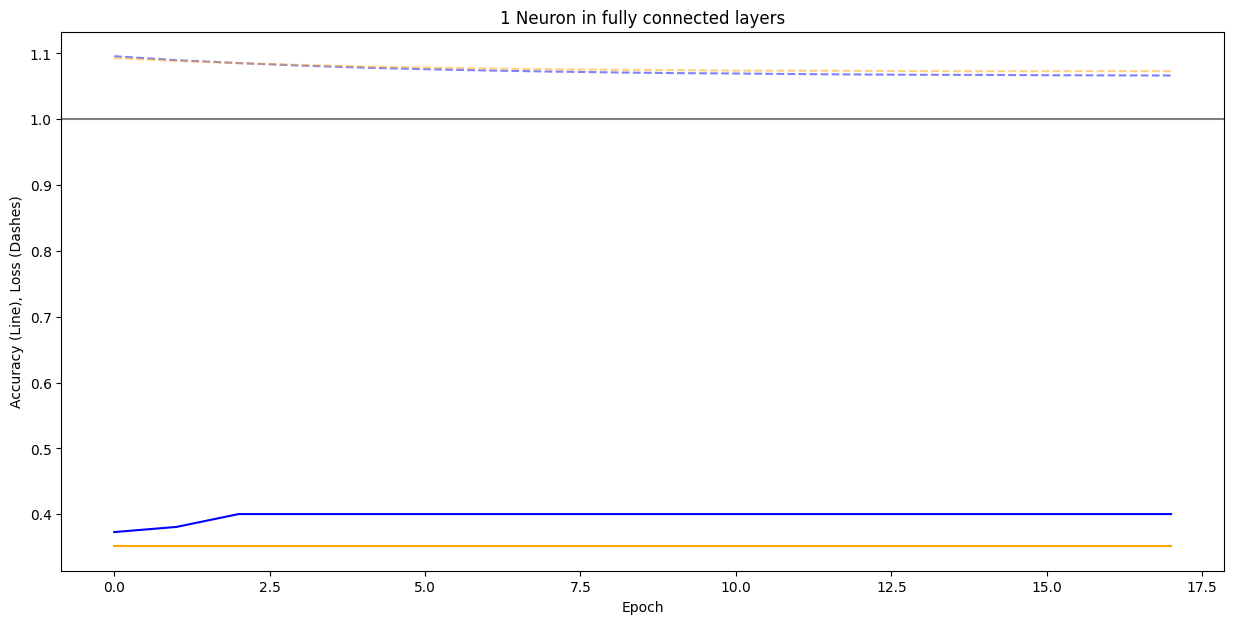

In [120]:
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']
accuracy_1 = history_1.history['accuracy']
val_accuracy_1 = history_1.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')
plt.title("1 Neuron in fully connected layers")
plt.plot(accuracy_1, color='blue')
plt.plot(val_accuracy_1, color='orange')
plt.plot(loss_1, '--', color='blue', alpha=0.5)
plt.plot(val_loss_1, '--', color='orange', alpha=0.5)

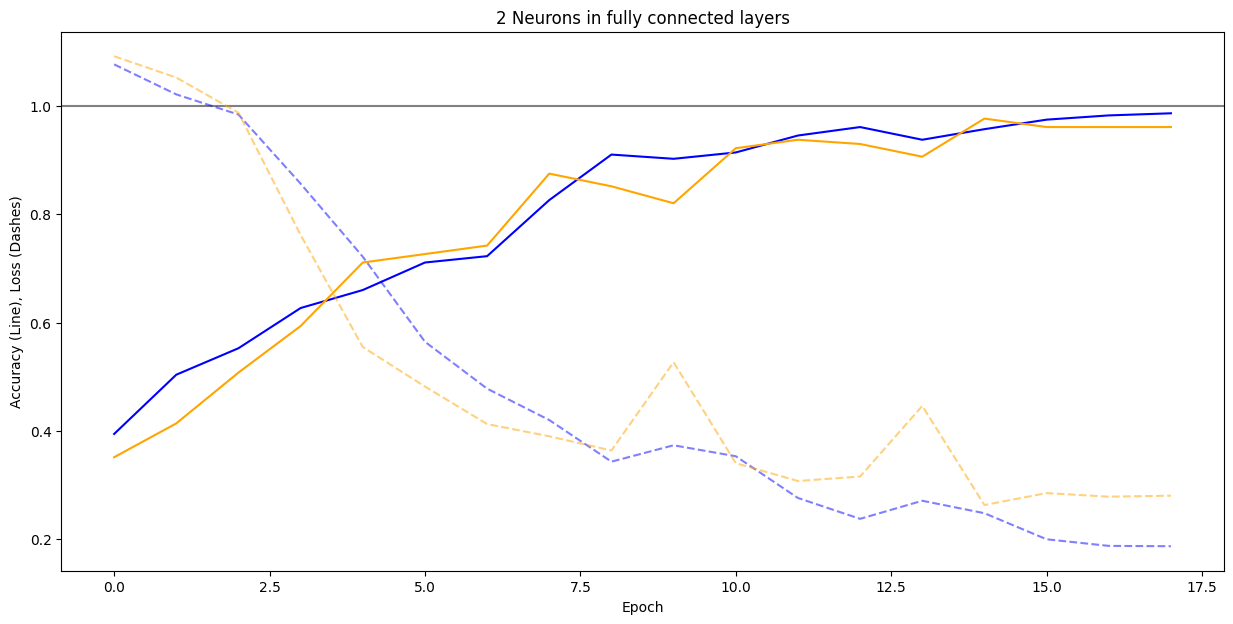

In [122]:
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
accuracy_2 = history_2.history['accuracy']
val_accuracy_2 = history_2.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')
plt.title("2 Neurons in fully connected layers")
plt.plot(accuracy_2, color='blue')
plt.plot(val_accuracy_2, color='orange')
plt.plot(loss_2, '--', color='blue', alpha=0.5)
plt.plot(val_loss_2, '--', color='orange', alpha=0.5)

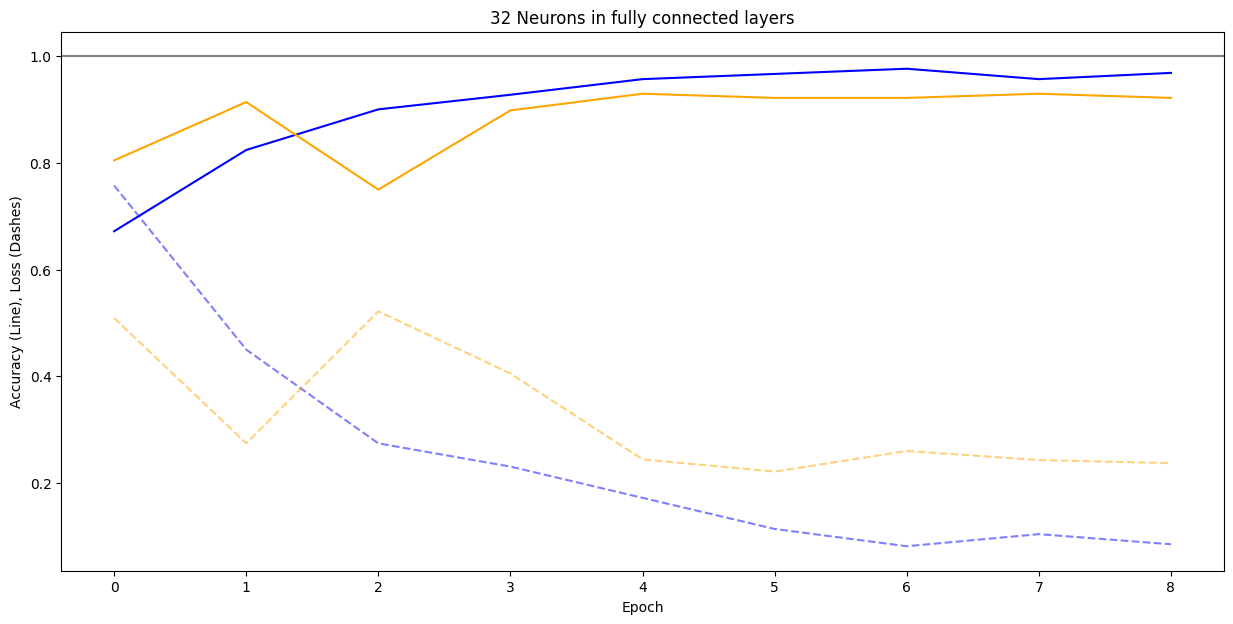

In [125]:
loss_32 = history_32.history['loss']
val_loss_32 = history_32.history['val_loss']
accuracy_32 = history_32.history['accuracy']
val_accuracy_32 = history_32.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')
plt.title("32 Neurons in fully connected layers")
plt.plot(accuracy_32, color='blue')
plt.plot(val_accuracy_32, color='orange')
plt.plot(loss_32, '--', color='blue', alpha=0.5)
plt.plot(val_loss_32, '--', color='orange', alpha=0.5)

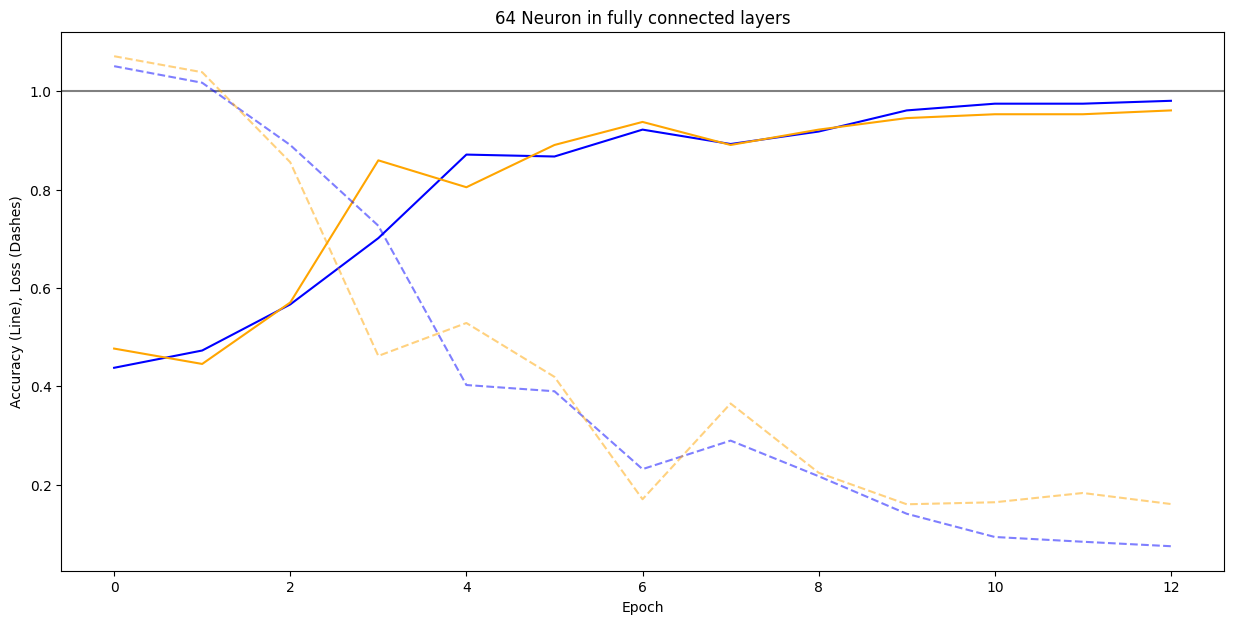

In [107]:
loss_64 = history_64.history['loss']
val_loss_64 = history_64.history['val_loss']
accuracy_64 = history_64.history['accuracy']
val_accuracy_64 = history_64.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')
plt.title("64 Neuron in fully connected layers")
plt.plot(accuracy_64, color='blue')
plt.plot(val_accuracy_64, color='orange')
plt.plot(loss_64, '--', color='blue', alpha=0.5)
plt.plot(val_loss_64, '--', color='orange', alpha=0.5)

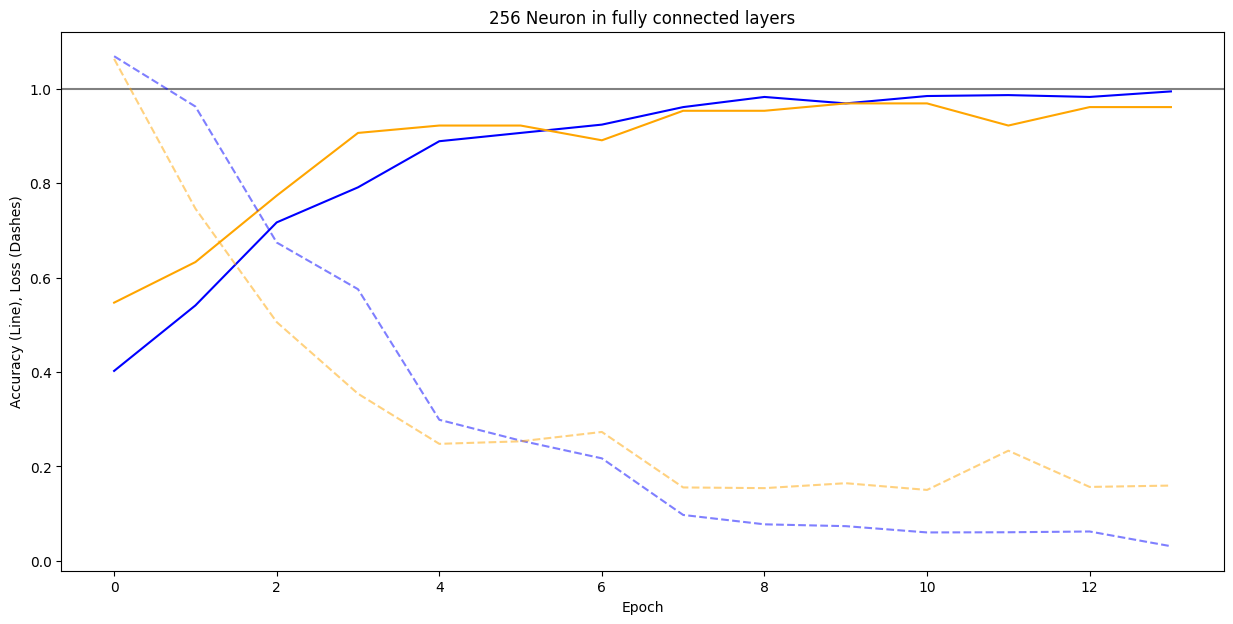

In [108]:
loss_256 = history_256.history['loss']
val_loss_256 = history_256.history['val_loss']
accuracy_256 = history_256.history['accuracy']
val_accuracy_256 = history_256.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')
plt.title("256 Neuron in fully connected layers")
plt.plot(accuracy_256, color='blue')
plt.plot(val_accuracy_256, color='orange')
plt.plot(loss_256, '--', color='blue', alpha=0.5)
plt.plot(val_loss_256, '--', color='orange', alpha=0.5)

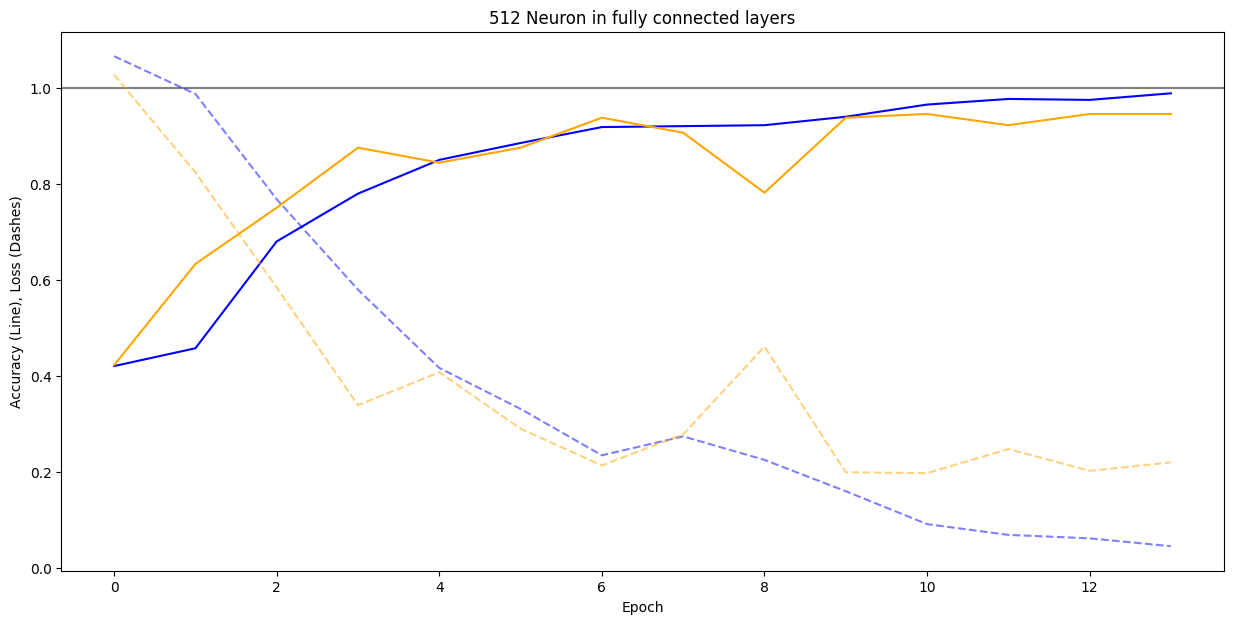

In [109]:
loss_512 = history_512.history['loss']
val_loss_512 = history_512.history['val_loss']
accuracy_512 = history_512.history['accuracy']
val_accuracy_512 = history_512.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')
plt.title("512 Neuron in fully connected layers")
plt.plot(accuracy_512, color='blue')
plt.plot(val_accuracy_512, color='orange')
plt.plot(loss_512, '--', color='blue', alpha=0.5)
plt.plot(val_loss_512, '--', color='orange', alpha=0.5)

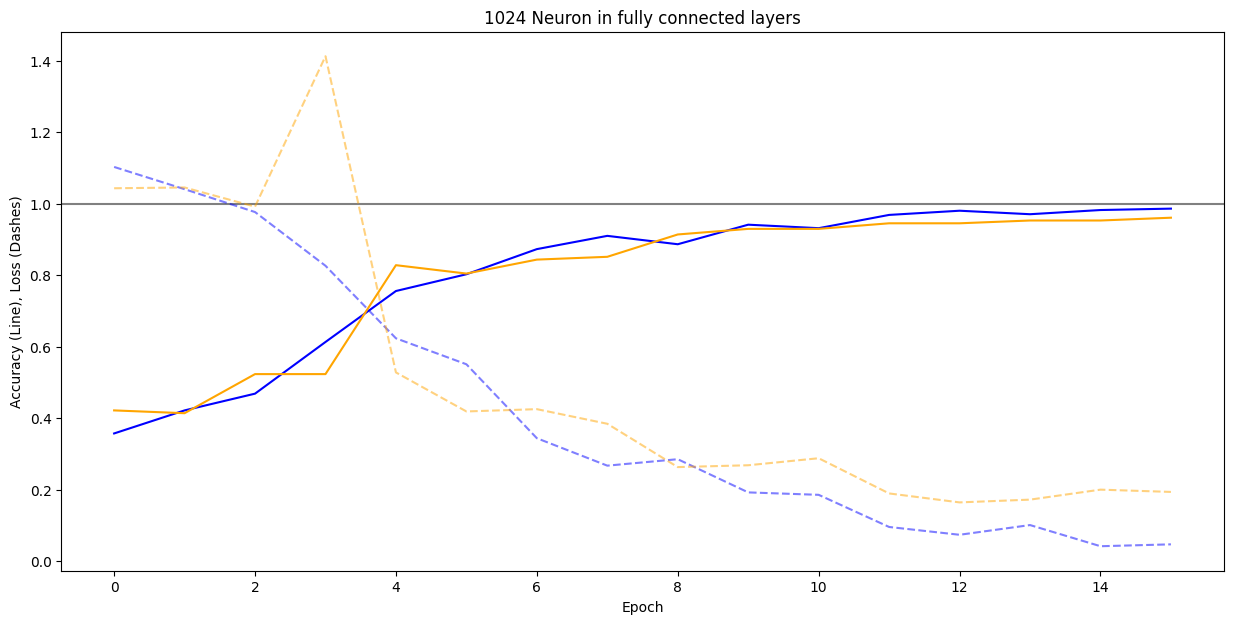

In [110]:
loss_1024 = history_1024.history['loss']
val_loss_1024 = history_1024.history['val_loss']
accuracy_1024 = history_1024.history['accuracy']
val_accuracy_1024 = history_1024.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')
plt.title("1024 Neuron in fully connected layers")
plt.plot(accuracy_1024, color='blue')
plt.plot(val_accuracy_1024, color='orange')
plt.plot(loss_1024, '--', color='blue', alpha=0.5)
plt.plot(val_loss_1024, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [111]:
model_512.save('gesture_recognition_512_neuron')
model_1024.save('gesture_recognition_1024_neuron')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

INFO:tensorflow:Assets written to: gesture_recognition_512_neuron\assets


INFO:tensorflow:Assets written to: gesture_recognition_512_neuron\assets


INFO:tensorflow:Assets written to: gesture_recognition_1024_neuron\assets


INFO:tensorflow:Assets written to: gesture_recognition_1024_neuron\assets


### visualize classification results with a confusion matrix

#### Model_1

4/4 [==============================] - 1s 111ms/step
before [[0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.37463307 0.23424341 0.39112353]
 [0.

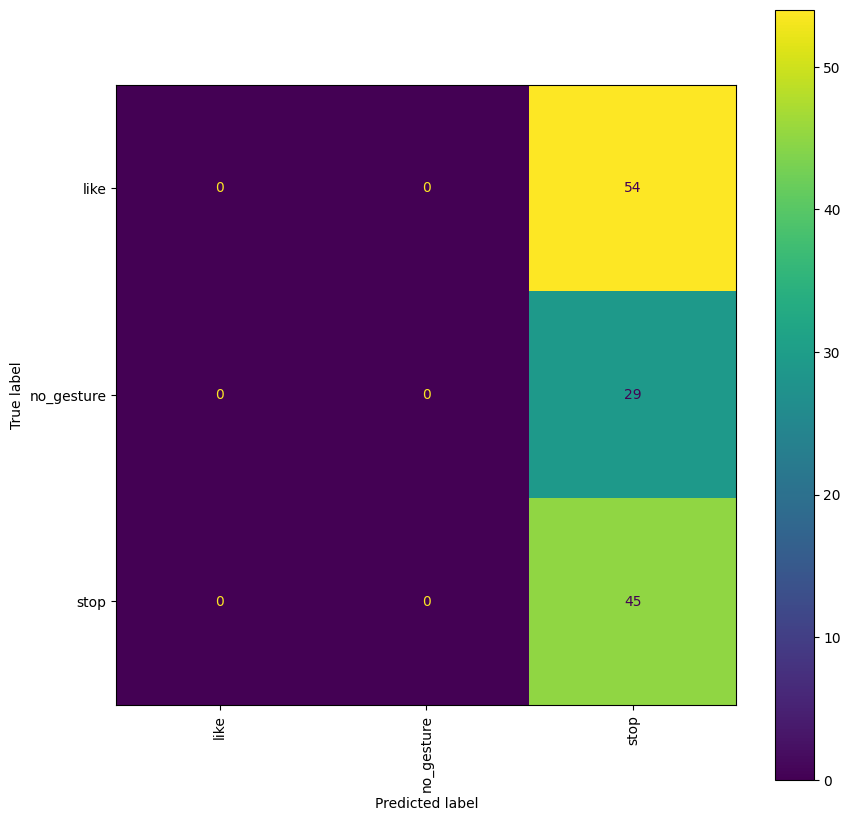

In [112]:
# let the model make predictions for our training data
y_predictions = model_1.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

#### Model_2

4/4 [==============================] - 1s 92ms/step
before [[9.89295244e-02 4.43776697e-03 8.96632731e-01]
 [9.98127520e-01 1.76311156e-03 1.09365559e-04]
 [9.99299288e-01 5.55865001e-04 1.44840000e-04]
 [6.08329856e-06 4.87231819e-06 9.99989033e-01]
 [9.99761045e-01 2.30438396e-04 8.41893961e-06]
 [9.99987245e-01 1.24993931e-05 2.14077602e-07]
 [9.99998927e-01 1.07539381e-06 1.70373724e-08]
 [3.31961989e-01 4.92290020e-01 1.75747991e-01]
 [9.99932408e-01 6.57636701e-05 1.73426349e-06]
 [9.99313474e-01 6.55098876e-04 3.14056197e-05]
 [8.57131963e-05 1.55464440e-04 9.99758780e-01]
 [2.99534917e-01 4.91819829e-01 2.08645254e-01]
 [7.62973666e-01 1.93403333e-01 4.36229147e-02]
 [8.15059611e-05 1.02066544e-04 9.99816477e-01]
 [9.99999762e-01 2.89643168e-07 1.86439975e-09]
 [1.70100626e-04 3.07893177e-04 9.99521971e-01]
 [2.99534917e-01 4.91819829e-01 2.08645254e-01]
 [1.70367148e-05 2.88917090e-05 9.99954104e-01]
 [2.99534917e-01 4.91819829e-01 2.08645254e-01]
 [2.62350954e-06 4.80824701e-

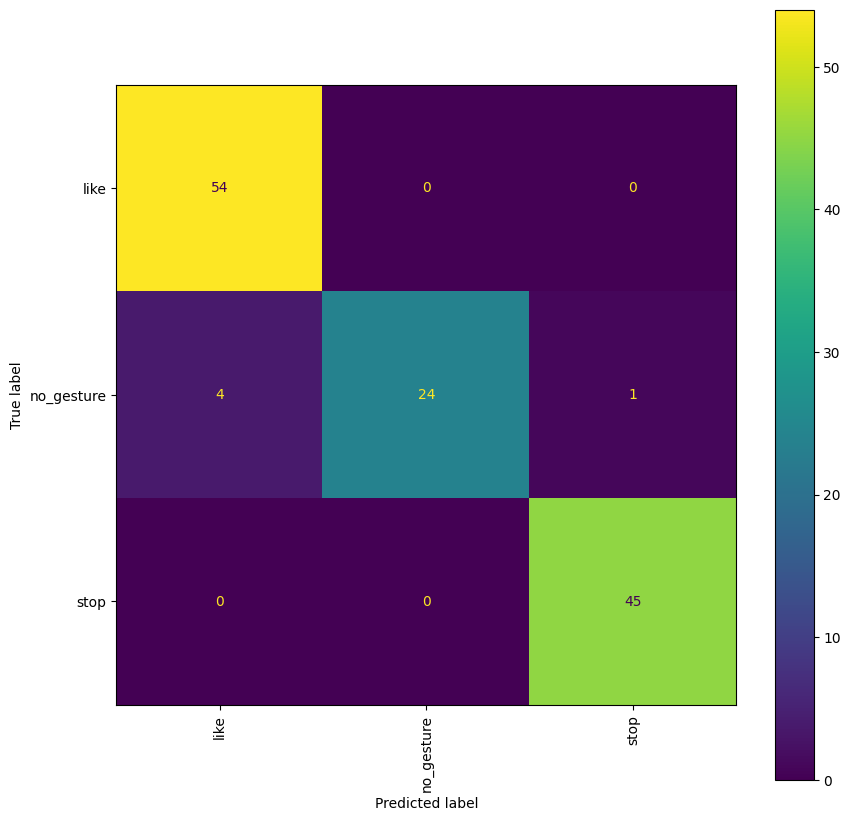

In [113]:
# let the model make predictions for our training data
y_predictions = model_2.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

#### Model_32

4/4 [==============================] - 1s 98ms/step
before [[3.70401293e-02 9.06381465e-05 9.62869227e-01]
 [9.99350369e-01 4.96694818e-04 1.52964829e-04]
 [9.74970698e-01 1.18486669e-05 2.50174720e-02]
 [2.38744845e-03 1.17330281e-04 9.97495294e-01]
 [9.99836802e-01 2.31396439e-06 1.60848067e-04]
 [9.99998808e-01 9.72934458e-07 1.98422853e-07]
 [9.99643922e-01 3.26060984e-07 3.55686963e-04]
 [5.20776995e-02 9.46332157e-01 1.59023190e-03]
 [9.99652624e-01 2.65651615e-05 3.20840802e-04]
 [9.97540593e-01 3.46804700e-05 2.42472859e-03]
 [3.67748030e-02 1.42850517e-03 9.61796701e-01]
 [9.47982073e-04 9.98794794e-01 2.57220730e-04]
 [8.66189957e-01 9.75420699e-02 3.62679735e-02]
 [5.65967103e-03 1.34070287e-03 9.92999673e-01]
 [9.99999881e-01 4.04851974e-08 9.80448860e-08]
 [1.53647864e-03 2.06685043e-03 9.96396720e-01]
 [4.50209220e-04 9.99495625e-01 5.40876608e-05]
 [1.03495969e-03 9.67373999e-05 9.98868346e-01]
 [1.48177193e-02 9.72942829e-01 1.22393817e-02]
 [6.19354798e-03 2.57811364e-

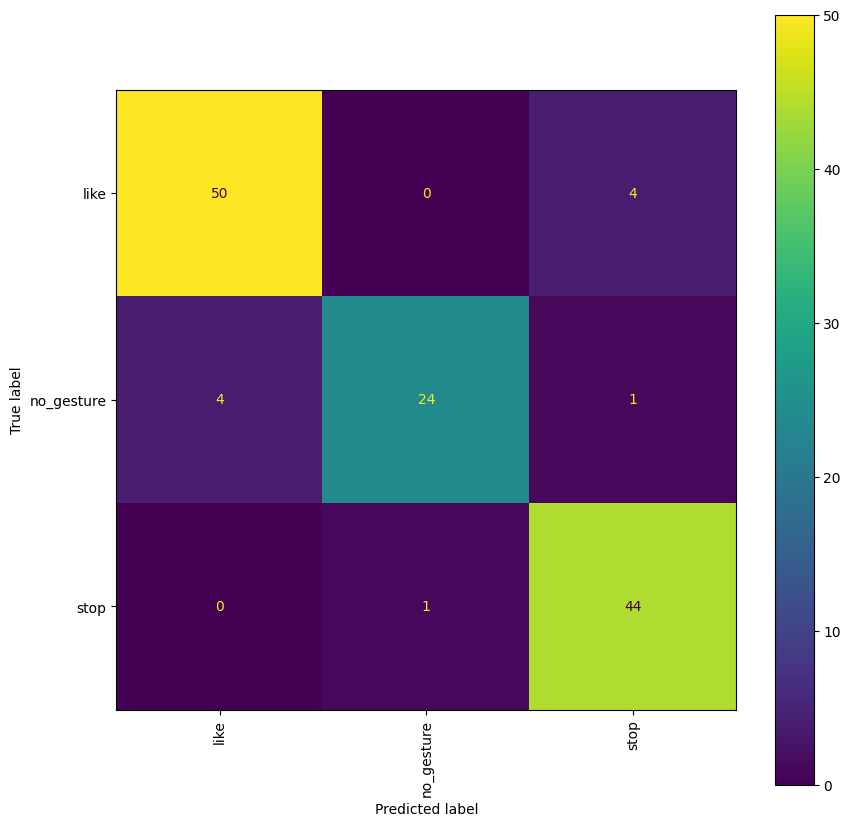

In [114]:
# let the model make predictions for our training data
y_predictions = model_32.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

#### Model_64

4/4 [==============================] - 1s 88ms/step
before [[1.09405890e-01 6.25207904e-04 8.89968872e-01]
 [9.98622537e-01 1.23436248e-03 1.43105950e-04]
 [9.92683709e-01 2.40965193e-04 7.07539031e-03]
 [9.78813696e-05 1.64982757e-05 9.99885559e-01]
 [9.99413371e-01 7.18685624e-05 5.14837448e-04]
 [9.99624372e-01 3.74506984e-04 1.11866473e-06]
 [9.99246359e-01 2.95244126e-06 7.50646112e-04]
 [1.21781668e-02 9.77669656e-01 1.01521946e-02]
 [9.99623895e-01 9.73485658e-05 2.78678723e-04]
 [9.99443829e-01 4.46759841e-05 5.11478283e-04]
 [9.46779177e-03 3.42733786e-03 9.87104893e-01]
 [4.42597820e-06 9.99949336e-01 4.62924436e-05]
 [7.96937823e-01 1.77014470e-01 2.60477830e-02]
 [2.97822803e-03 7.58423586e-04 9.96263325e-01]
 [9.99961615e-01 3.71029928e-05 1.27037697e-06]
 [4.15608380e-03 1.57075282e-02 9.80136395e-01]
 [1.24969802e-06 9.99994993e-01 3.79782045e-06]
 [1.48348056e-03 2.95817154e-04 9.98220742e-01]
 [5.72087127e-04 9.98373985e-01 1.05384516e-03]
 [1.16961681e-04 2.60113084e-

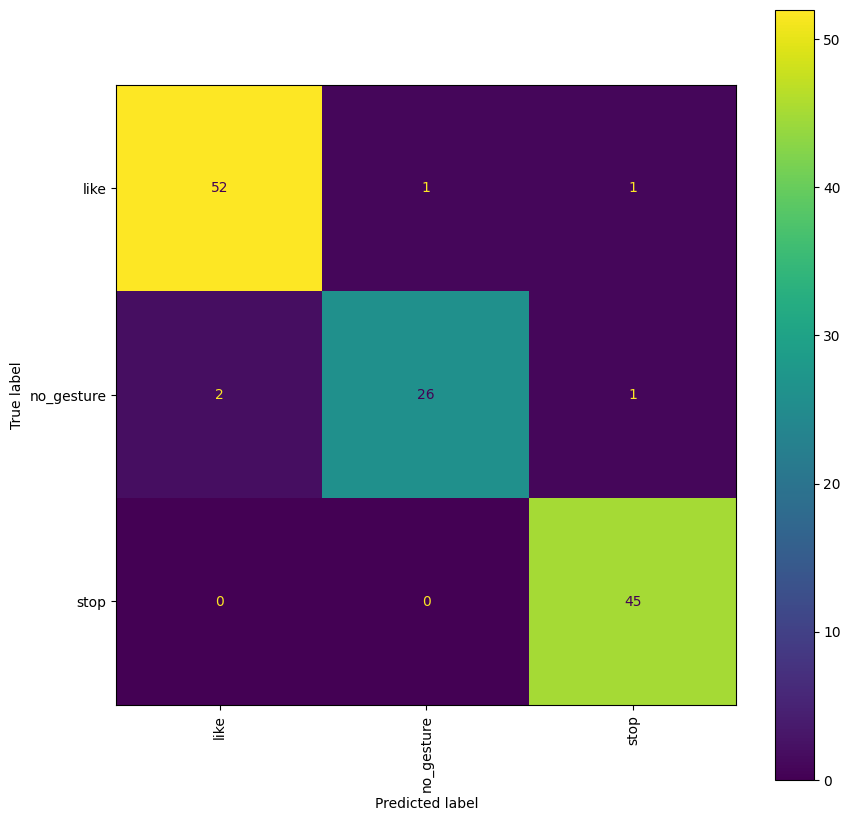

In [115]:
# let the model make predictions for our training data
y_predictions = model_64.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

#### Model_256

4/4 [==============================] - 1s 94ms/step
before [[1.70389947e-03 9.68898748e-05 9.98199284e-01]
 [9.99824226e-01 1.75592460e-04 2.71585122e-07]
 [9.99759853e-01 5.27034354e-05 1.87428508e-04]
 [5.03844458e-05 3.52129464e-05 9.99914408e-01]
 [9.99947309e-01 3.86244137e-05 1.40353250e-05]
 [9.99996185e-01 3.82997086e-06 8.61871425e-12]
 [1.00000000e+00 3.91746937e-08 1.68925247e-08]
 [5.10667600e-02 9.48753476e-01 1.79742899e-04]
 [9.99987364e-01 1.22443735e-05 3.47590657e-07]
 [9.99934912e-01 6.04846100e-05 4.68975441e-06]
 [2.01559014e-04 1.78237751e-04 9.99620199e-01]
 [8.66892321e-07 9.99999166e-01 2.60289390e-08]
 [8.14784825e-01 1.77799106e-01 7.41609698e-03]
 [8.74754332e-05 4.12294030e-04 9.99500275e-01]
 [9.99999881e-01 1.24212519e-07 1.22346772e-10]
 [4.24728118e-04 4.01154248e-04 9.99174058e-01]
 [3.84102492e-07 9.99999642e-01 1.53368918e-09]
 [1.02117829e-05 1.41725116e-06 9.99988317e-01]
 [1.42219476e-03 9.98004377e-01 5.73459140e-04]
 [1.57973216e-06 3.12311863e-

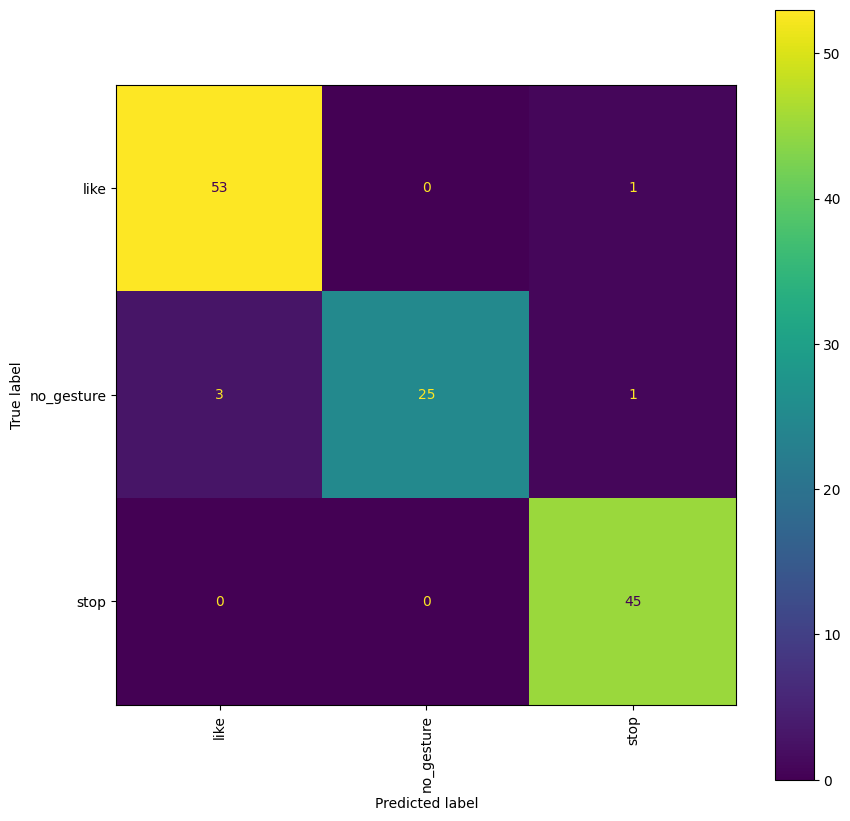

In [116]:
# let the model make predictions for our training data
y_predictions = model_256.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

#### Model_512

4/4 [==============================] - 0s 91ms/step
before [[2.1912582e-02 7.3139841e-04 9.7735608e-01]
 [9.9973816e-01 2.6084241e-04 8.9404318e-07]
 [9.9952853e-01 4.0511182e-04 6.6387089e-05]
 [1.5607982e-05 7.2278294e-07 9.9998367e-01]
 [9.9942255e-01 5.4495112e-04 3.2514705e-05]
 [9.9999857e-01 1.3950282e-06 4.6604356e-11]
 [1.0000000e+00 1.3757985e-08 4.7666615e-10]
 [8.8897971e-03 9.9033737e-01 7.7285740e-04]
 [9.9997473e-01 2.4483148e-05 8.1482165e-07]
 [9.9970132e-01 2.6815027e-04 3.0507226e-05]
 [1.2677403e-04 1.7033421e-05 9.9985611e-01]
 [7.8067188e-08 9.9999988e-01 3.3607654e-09]
 [8.0931318e-01 1.8182282e-01 8.8639967e-03]
 [3.4467952e-04 4.1379473e-05 9.9961394e-01]
 [1.0000000e+00 4.5881080e-08 6.2361197e-12]
 [2.7853373e-04 1.6212475e-04 9.9955934e-01]
 [2.0411592e-08 1.0000000e+00 1.4236018e-10]
 [3.4181776e-06 5.1356074e-07 9.9999607e-01]
 [2.2822947e-03 9.9747974e-01 2.3798208e-04]
 [3.9638544e-06 4.2245055e-08 9.9999595e-01]
 [6.7069662e-01 2.3445342e-01 9.4849899e-

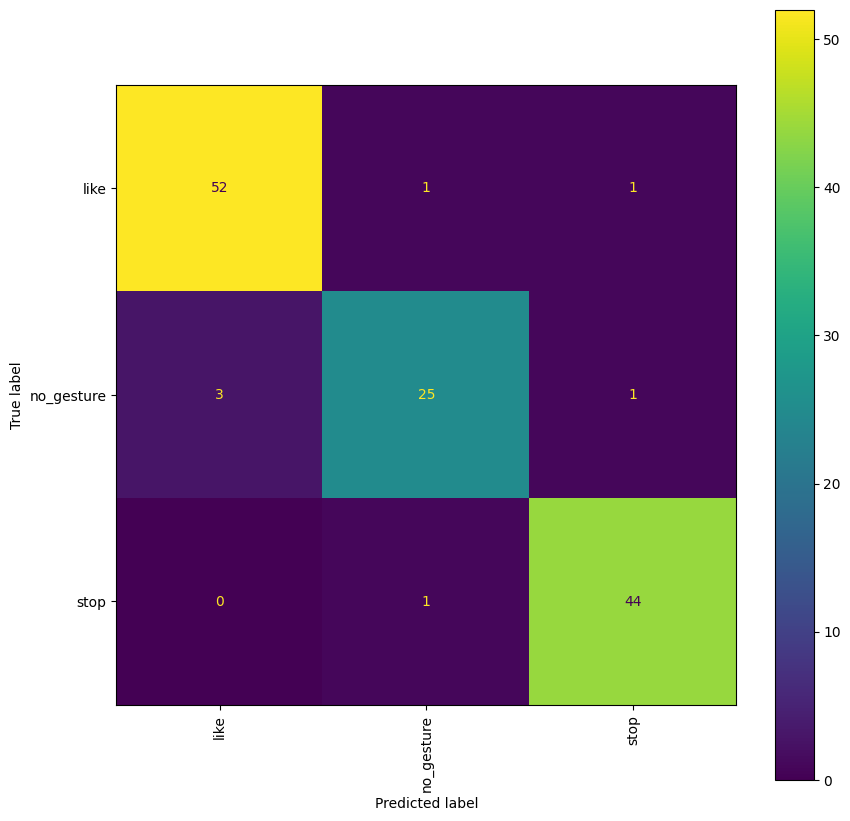

In [117]:
# let the model make predictions for our training data
y_predictions = model_512.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

#### Model_1024

4/4 [==============================] - 0s 91ms/step
before [[1.55754402e-01 8.05869116e-04 8.43439758e-01]
 [9.99998808e-01 1.18093567e-06 8.88875695e-10]
 [9.99978304e-01 1.50166125e-05 6.64898744e-06]
 [9.31951392e-04 3.50883033e-06 9.99064505e-01]
 [9.99979138e-01 1.71900010e-05 3.74620186e-06]
 [1.00000000e+00 3.54342250e-11 1.43041815e-16]
 [1.00000000e+00 4.58612384e-11 5.21713315e-13]
 [2.01477837e-02 9.79420900e-01 4.31353867e-04]
 [9.99998689e-01 1.29828720e-06 2.15473168e-08]
 [9.99987721e-01 1.04366582e-05 1.82416397e-06]
 [1.11439172e-03 1.13675429e-04 9.98771966e-01]
 [5.10034552e-05 9.99948740e-01 2.38090294e-07]
 [9.57390726e-01 3.76835689e-02 4.92570875e-03]
 [6.56521739e-03 4.24636673e-04 9.93010104e-01]
 [1.00000000e+00 3.75865051e-12 4.86042626e-17]
 [6.30582566e-04 2.10809085e-05 9.99348342e-01]
 [2.38206743e-09 1.00000000e+00 3.72000716e-13]
 [5.96139871e-04 3.80286906e-06 9.99400020e-01]
 [5.27105900e-03 9.94535089e-01 1.93849293e-04]
 [1.71755732e-04 2.62908702e-

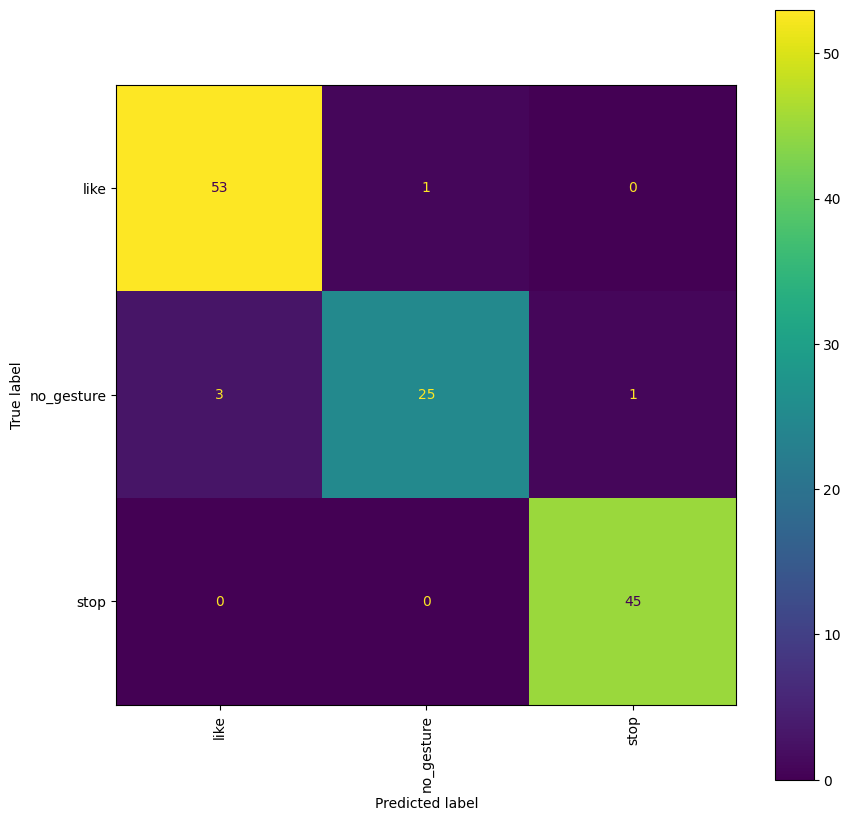

In [118]:
# let the model make predictions for our training data
y_predictions = model_1024.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

### Result

Using only 1 neuron in the fully connected layer did not yield satisfactory results in any case. The overall accuracy was low, and the model struggled to capture the complexities of the data.

With 2 neurons in the fully connected layer, the overall accuracy showed improvement. However, there was high volatility in the curves, this suggests that the model may not have converged to a stable solution.

Increasing the number of neurons to 32 resulted in reduced volatility in the curves. However, there were still notable variations in accuracy, loss, and validation accuracy/loss.

With 64, 256, 512, and 1024 neurons in the fully connected layers, the accuracy reached close to 1 after 12 epochs of training. However, it is worth noting that the model with 1024 neurons did not initially perform as well as the models with 32, 64, and 256 neurons in terms of accuracy. The models with 32, 64, and 256 neurons achieved higher accuracy in the early stages of prediction compared to the model with 1024 neurons. This suggests that the models with a moderate number of neurons initially captured the important features of the data more effectively. However, as the training progressed, all models eventually achieved similar high levels of accuracy.

In terms of training time, excluding the condition with only 1 neuron, it appears that the more neurons there are, the longer it takes to train the model. However, the results from the confusion matrix showed that using 1024 neurons slightly improved the performance.

The choice of the number of neurons in the fully connected layers should be based on a balance between model capacity and overfitting. Too few neurons may limit the model's ability to learn complex patterns, while too many neurons may lead to overfitting and increased computational requirements.